In [1]:
impo

NameError: name '__file__' is not defined

In [1]:
import peartree as pt
print('peartree version: %s ' % pt.__version__)
import networkx as nx
print('networkx version: %s ' % nx.__version__)
import matplotlib as mpl
print('matplotlib version: %s ' % mpl.__version__)
import osmnx as ox
print('osmnx version: %s ' % ox.__version__)
import os, sys
import pandas as pd, geopandas as gpd

peartree version: 0.5.1 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 


In [2]:
feed = pt.get_representative_feed(os.path.join(r'C:\Users\WB411133\Downloads', 'ladotgtfs.zip'))
start = 7 * 60 * 60
end = 9 * 60 * 60
%time Gtransit = pt.load_feed_as_graph(feed, start, end)

Wall time: 21.3 s


In [4]:
import geopandas as gpd
from shapely.geometry import Point

# We need a coverage area, based on the points from the
# New Orleans GTFS data, which we can pull from the peartree
# network graph by utilizing coordinate values and extracting
# a convex hull from the point cloud
boundary = gpd.GeoSeries(
    [Point(n['x'], n['y']) for i, n in Gtransit.nodes(data=True)]
    ).unary_union.convex_hull

### Pull in the walking and driving networks with OSMnx

In [5]:
%time Gwalk = ox.graph_from_polygon(boundary, network_type='walk')
#%time Gdrive = ox.graph_from_polygon(boundary, network_type='drive')

Wall time: 6min


### Functions

In [9]:
def node_gdf_from_graph(G, crs = {'init' :'epsg:4326'}, attr_list = None):
    
    #### Function for generating GeoDataFrame from Graph ####
    # REQUIRED: a graph object G
    # OPTIONAL: crs - projection of format {'init' :'epsg:4326'}. Defaults to WGS84. 
    #           note: defining crs of the data, does NOT reproject to this crs
    #           attr_list: list of the keys which you want to be moved over to the GeoDataFrame, if not all
    # RETURNS: a geodataframe of the node objects in the graph
    # -------------------------------------------------------------------------#
    
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Point
    
    nodes = []
    
    for u, data in list(G.nodes(data=True))[:1]:
            
        if attr_list == None:
            ittr_list = list(data.keys())
            ittr_list.remove('x')
            ittr_list.remove('y')
    
        attr_list = ittr_list     
    
    for u, data in G.nodes(data=True):
        
        new_column_info = {
            'node_ID':u,
            'y':data['y'],
            'x':data['x'],
            'geometry':Point((data['x'], data['y']))
            }
        
        for i in attr_list:
            new_column_info[i] = data[i]
                
        nodes.append(new_column_info)
            
    nodes_df = pd.DataFrame(nodes)
    nodes_df = nodes_df.drop_duplicates(subset=['node_ID'], keep='first')
    nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=nodes_df.geometry, crs = crs)
    
    return nodes_gdf

In [14]:
# test
Gwalk_nodes_gdf = node_gdf_from_graph(Gwalk, attr_list = ['osmid'])
Gwalk_nodes_gdf.head(3)

,geometry,node_ID,osmid,x,y
0,POINT (-90.1063393 30.0085142),115998720,115998720,-90.106339,30.008514
1,POINT (-90.0679828 29.9381084),116064256,116064256,-90.067983,29.938108
2,POINT (-90.23719699999999 30.032546),115539969,115539969,-90.237197,30.032546


In [10]:
def edge_gdf_from_graph(G, crs = {'init' :'epsg:4326'}, attr_list = None):
    
    #### Function for generating GeoDataFrame from Graph ####
    # REQUIRED: a graph object G
    # OPTIONAL: crs - projection of format {'init' :'epsg:4326'}. Defaults to WGS84
    #           attr_list: list of the keys which you want to be moved over to the GeoDataFrame 
    # RETURNS: a GeoDataFrame object of the edges in the graph
    # -------------------------------------------------------------------------#
    
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import LineString

    edges = []
    
    for u, v, data in list(G.edges(data=True))[:1]:
            
        if attr_list == None:
            ittr_list = list(data.keys())
            if 'geometry' in ittr_list:
                ittr_list = ittr_list.remove('geometry')
            
    attr_list = ittr_list   
    
    for u, v, data in G.edges(keys=False, data=True):
                
        if 'geometry' in data:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            geom = data['geometry']

        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            geom = LineString([(x1, y1), (x2, y2)])        

        new_column_info = {
            'stnode':u,
            'endnode':v,
            'geometry':geom}
    
        for i in attr_list:
            try:
                new_column_info[i] = data[i]
            except: 
                pass
        
        edges.append(new_column_info)        
    
    edges_df = pd.DataFrame(edges)
    edges_gdf = gpd.GeoDataFrame(edges_df, geometry = edges_df.geometry, crs = crs)
    
    return edges_gdf

In [16]:
# test
Gwalk_edges_gdf = edge_gdf_from_graph(Gwalk, attr_list = ['highway','length'])
Gwalk_edges_gdf.head(3)

,stnode,endnode,highway,length,geometry
0,115998720,116012585,residential,96.733,"LINESTRING (-90.1063393 30.0085142, -90.10534 ..."
1,115998720,115998723,residential,201.270,"LINESTRING (-90.1063393 30.0085142, -90.106119..."
2,115998720,115998716,residential,200.332,"LINESTRING (-90.1063393 30.0085142, -90.106543..."


In [17]:
def snap_points_to_graph(points, G, crs = None):
    
    #### Function for generating GeoDataFrame from Graph ####
    # REQUIRED: a GeoDataFrame of point objects (points_gdf)
    #           a Graph object or geodataframe 
    # RETURNS:  an augmented version of the input GeoDataFrame with the node_ID of 
    #           the nearest nodes to the points in the graph
    # Note:     ensure any GeoDataFrames are in the same projection 
    #           before using function, or pass a crs
    # -------------------------------------------------------------------------#
    
    import networkx as nx
    import geopandas as gpd
    from shapely.ops import nearest_points

    if type(G) == nx.classes.multidigraph.MultiDiGraph:
        graph_gdf = node_gdf_from_graph(G)
            
    elif type(G) == gpd.geodataframe.GeoDataFrame:
        graph_gdf = G
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')
    
    if crs != None and graph_gdf.crs != crs:
            graph_gdf = graph_gdf.to_crs(crs)
    
    if points.crs != graph_gdf.crs:
        raise ValueError('crs mismatch detected! aborting process')
    
    graph_gdf_uu = graph_gdf.geometry.unary_union
    
    def near(point, graph_gdf_uu):
        nearest = graph_gdf.geometry == nearest_points(point, graph_gdf_uu)[1]
        return graph_gdf[nearest].node_ID.get_values()[0]
        
    points['Nearest_node'] = points.apply(lambda x: near(x.geometry, graph_gdf_uu), axis=1)
    
    return points

In [18]:
# test
pointsdf = gpd.read_file(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree','points.shp'))
pointsdf = snap_points_to_graph(pointsdf, Gwalk)
pointsdf.head(3)

,id,geometry,Nearest_node
0,1,POINT (-90.14621339084378 30.01080620822039),115576067
1,2,POINT (-90.10344351744249 30.00741973730592),116047459
2,3,POINT (-90.08964678408722 29.96866345906251),116042005


In [19]:
def graph_nodes_intersecting_polygon(G, polygons, crs = None):
    
    #### Function for generating GeoDataFrame from Graph ####
    # REQUIRED: a GeoDataFrame containing one or more polygons
    #           a Graph object or geodataframe 
    # RETURNS:  a list of the nodes intersecting the polygons
    # Note:     ensure any GeoDataFrames are in the same projection 
    #           before using function, or pass a crs
    # -------------------------------------------------------------------------#
    
    import networkx as nx
    import geopandas as gpd

    if type(G) == nx.classes.multidigraph.MultiDiGraph:
        graph_gdf = node_gdf_from_graph(G)
            
    elif type(G) == gpd.geodataframe.GeoDataFrame:
        graph_gdf = G
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')
    
    if type(polygons) != gpd.geodataframe.GeoDataFrame:
        raise ValueError('Expecting a geodataframe for polygon(s)!')
        
    if crs != None and graph_gdf.crs != crs:
            graph_gdf = graph_gdf.to_crs(crs)
    
    if crs != None and polygons.crs != crs:
            polygons = polygons.to_crs(crs)
    
    if polygons.crs != graph_gdf.crs:
        raise ValueError('crs mismatch detected! aborting process')
    
    aggs = []
    for poly in polygons.geometry:
        
        def chck(x, poly):
            if poly.contains(x):
                return 1
            else:
                return 0
        
        graph_gdf['intersecting'] = graph_gdf['geometry'].apply(lambda x: chck(x, poly))
        aggs.append(list(graph_gdf['node_ID'].loc[graph_gdf['intersecting'] == 1]))
    
    aggs = [j for i in aggs for j in i]
    aggs = list(set(aggs))
    return aggs

In [20]:
#test
polygons = gpd.read_file(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree','polygons.shp'))
A = graph_nodes_intersecting_polygon(Gwalk, polygons)

In [21]:
def graph_edges_intersecting_polygon(G, polygons, mode = 'contains', crs = None):
    
    #### Function for identifying intersecting edges of a graph with polygon(s) ####
    # REQUIRED: a GeoDataFrame containing one or more polygons
    #           a Graph object
    #           mode - a string, either 'contains' or 'intersecting'
    # RETURNS:  a list of the edges intersecting the polygons
    # Note:     ensure any GeoDataFrames are in the same projection 
    #           before using function, or pass a crs
    # -------------------------------------------------------------------------#
    
    import networkx as nx
    import geopandas as gpd

    if type(G) == nx.classes.multidigraph.MultiDiGraph:
        node_graph_gdf = node_gdf_from_graph(G)
        edge_graph_gdf = edge_gdf_from_graph(G)
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')
    
    if type(polygons) != gpd.geodataframe.GeoDataFrame:
        raise ValueError('Expecting a geodataframe for polygon(s)!')
        
    if crs != None and node_graph_gdf.crs != crs:
            node_graph_gdf = node_graph_gdf.to_crs(crs)
    
    if crs != None and polygons.crs != crs:
            polygons = polygons.to_crs(crs)
    
    if polygons.crs != node_graph_gdf.crs:
        raise ValueError('crs mismatch detected! aborting process')
        
    intersecting_nodes = graph_nodes_intersecting_polygon(node_graph_gdf, polygons, crs)
        
    if mode == 'contains':
        edge_graph_gdf = edge_graph_gdf.loc[(edge_graph_gdf.stnode.isin(intersecting_nodes)) &
                                 (edge_graph_gdf.endnode.isin(intersecting_nodes))]
    elif mode == 'intersects':
        edge_graph_gdf = edge_graph_gdf.loc[(edge_graph_gdf.stnode.isin(intersecting_nodes)) |
                                 (edge_graph_gdf.endnode.isin(intersecting_nodes))]
    
    return edge_graph_gdf

In [22]:
#test
polygons = gpd.read_file(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree','polygons.shp'))
l_inter = graph_edges_intersecting_polygon(Gwalk, polygons, mode = 'intersects')
l_contains = graph_edges_intersecting_polygon(Gwalk, polygons, mode = 'contains')

In [23]:
def sample_raster(G, tif_path, property_name = 'RasterValue'):
    
    #### Function for attaching raster values to corresponding graph nodes ####
    # REQUIRED: a graph containing one or more nodes
    #           a raster or path to a tif
    #           a property name for the value of the raster attached to the node
    # RETURNS:  a graph 
    # Note:     ensure any GeoDataFrames / graphs are in the same projection 
    #           before using function, or pass a crs
    # -------------------------------------------------------------------------#
    
    import rasterio
    
    if type(G) == nx.classes.multidigraph.MultiDiGraph or type(G) == nx.classes.digraph.DiGraph:
        pass        
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')
    
    # generate dictionary of {node ID: point} pairs
    try:
        list_of_nodes = {}
        for u, data in G.nodes(data=True):
            list_of_nodes.update({u:(data['x'], data['y'])})
    except:
        raise ValueError('loading point geometry went wrong. Ensure data dict includes x, y values!')
    
    # load raster
    try:
        dataset = rasterio.open(os.path.join(tif_path))
    except:
        raise ValueError('Expecting a path to a .tif file!')

    # create list of values
    raster_values = list(dataset.sample(list_of_nodes.values()))
    raster_values = [x[0] for x in raster_values]
    
    # generate new dictionary of {node ID: raster values}
    ref = dict(zip(list_of_nodes.keys(), raster_values))
    
    # load new values onto node data dictionary
    for u, data in G.nodes(data=True):
        data[property_name] = ref[u]
        
    return G

In [24]:
# test
landslide = r'C:\Users\charl\Documents\GOST\Peartree\Global.tif'
Gwalk_landslide = sample_raster(Gwalk, landslide, 'landslide_chance')
for i in list(Gwalk.nodes(data=True))[:3]:
    print(i)

(115998720, {'y': 30.0085142, 'x': -90.1063393, 'osmid': 115998720, 'landslide_chance': 1})
(116064256, {'y': 29.9381084, 'x': -90.0679828, 'osmid': 116064256, 'landslide_chance': 1})
(115539969, {'y': 30.032546, 'x': -90.237197, 'osmid': 115539969, 'landslide_chance': 1})


In [152]:
def generate_isochrones(G, origins, thresh, weight = None, stacking = False):

    #### Function for generating isochrones from one or more graph nodes ####
    # REQUIRED: G - a graph containing one or more nodes
    #           origins - a list of node IDs that the isochrones are to be generated from
    #           thresh - the time threshold for the calculation of the isochrone
    # OPTIONAL: weight - name of edge weighting for calculating 'distances'. For isochrones, should be 
    #           time expressed in seconds. Defaults to time expressed in seconds.
    #           stacking - if True, returns number of origins that can be reached from that node. If false, max = 1
    # RETURNS:  the original graph with a new data property for the nodes and edges included in the isochrone
    # Note:     ensure any GeoDataFrames / graphs are in the same projection 
    #           before using function, or pass a crs
    # -------------------------------------------------------------------------#    
    
    from collections import Counter
    
    if type(origins) == list and len(origins) >= 1:
        pass
    else:
        raise ValueError('Ensure isochrone centers (origins object) is a list containing at least one node ID!')
    
    ddict = list(G.nodes(data = True))[:1][0][1]
    
    if weight == None:
        if 'time' not in ddict.keys():
            raise ValueError('need "time" key in edge value dictionary!')
        else:
            weight = 'time'
    
    sub_graphs = []
    for node in origins:
        sub_graphs.append(nx.ego_graph(G, node, thresh, distance = weight))
    
    reachable_nodes = []
    for graph in sub_graphs:
        reachable_nodes.append(list(graph.nodes))
    
    reachable_nodes = [j for i in reachable_nodes for j in i]
    
    if stacking == False:
        
        reachable_nodes = set(reachable_nodes)
    
        for u, data in G.nodes(data=True):
            if u in reachable_nodes:
                data[thresh] = 1
            else:
                data[thresh] = 0

    elif stacking == True:
        
        reachable_nodes = Counter(reachable_nodes)   
        
        for u, data in G.nodes(data=True):
            if u in reachable_nodes:
                data[thresh] = reachable_nodes[u]
            else:
                data[thresh] = 0
    else:
        raise ValueError('stacking must either be True or False!')
    
    return G

In [153]:
# test
thresh = 5000
origins = [115540004, 115539962, 115605524, 116064206]
iso_Gwalk = generate_isochrones(Gwalk, origins, thresh, weight = 'length', stacking = True)

C:\Users\charl\AppData\Local\Continuum\anaconda3\envs\Tensorflow\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


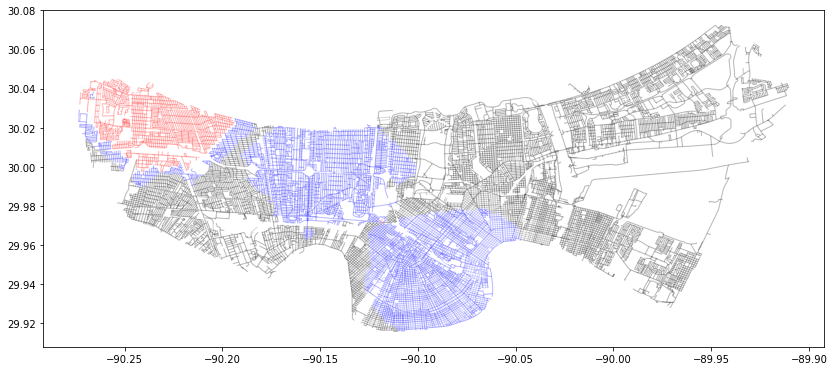

In [154]:
# visualize test

nodes = node_gdf_from_graph(iso_Gwalk)
edges = edge_gdf_from_graph(iso_Gwalk)
edges['ID'] = edges.index

zero_reachable_nodes = nodes.loc[nodes[thresh] == 0]
one_reachable_nodes = nodes.loc[nodes[thresh] == 1]
two_reachable_nodes = nodes.loc[nodes[thresh] == 2]
three_reachable_nodes = nodes.loc[nodes[thresh] == 3]

zero_reachable_edges = edges.loc[(edges.stnode.isin(zero_reachable_nodes.node_ID)) | (edges.endnode.isin(zero_reachable_nodes.node_ID))]
one_reachable_nodes = edges.loc[(edges.stnode.isin(one_reachable_nodes.node_ID)) & (edges.endnode.isin(one_reachable_nodes.node_ID))]
two_reachable_nodes = edges.loc[(edges.stnode.isin(two_reachable_nodes.node_ID)) & (edges.endnode.isin(two_reachable_nodes.node_ID))]
three_reachable_nodes = edges.loc[(edges.stnode.isin(three_reachable_nodes.node_ID)) & (edges.endnode.isin(three_reachable_nodes.node_ID))]

gdf_bin = [zero_reachable_edges, one_reachable_nodes, two_reachable_nodes, three_reachable_nodes]
colors = ['black', 'blue','red','yellow']

# Hold onto the axis state between plots
ax = None

# Note: Reversing order of both so that lightest is drawn first, others
#       are then stacked on top (as they get darker)

for gdf, col in zip((gdf_bin),(colors)):
    
    # Plot parameters
    a = 0.15
    lw = 1
    if ax is not None:
        gdf.plot(ax=ax, linewidth=lw, alpha=a, color=col, markersize=3)
    else:
        ax = gdf.plot(figsize=(14,14), linewidth=lw, alpha=a, color=col, markersize=3)

In [209]:
def make_iso_polys(G, origins, trip_times, edge_buff=25, node_buff=50, infill=False, weight = None, crs = None):
    
    from shapely.geometry import LineString
    
    default_crs = {'init':'epsg:4326'}
    
    ddict = list(G.nodes(data = True))[:1][0][1]

    if type(origins) == list and len(origins) >= 1:
        pass
    else:
        raise ValueError('Ensure isochrone centers ("origins" object) is a list containing at least one node ID!')
        
    if weight == None:
        if 'time' not in ddict.keys():
            raise ValueError('need "time" key in edge value dictionary!')
        else:
            weight = 'time'
    
    isochrone_polys, nodez, tt = [], [], []
       
    for trip_time in sorted(trip_times, reverse=True):
        
        for _node_ in origins:

            subgraph = nx.ego_graph(G, _node_, radius = trip_time, distance = weight)

            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points, crs = default_crs)
            nodes_gdf = nodes_gdf.set_index('id')

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                f = nodes_gdf.loc[n_fr].geometry
                t = nodes_gdf.loc[n_to].geometry
                edge_lines.append(LineString([f,t]))
            
            edge_gdf = gpd.GeoDataFrame({'geoms':edge_lines}, geometry = 'geoms', crs = default_crs)

            if crs != None and nodes_gdf.crs != crs:
                nodes_gdf = nodes_gdf.to_crs(crs)
                edge_gdf = edge_gdf.to_crs(crs)
            
            n = nodes_gdf.buffer(node_buff).geometry
            e = edge_gdf.buffer(edge_buff).geometry
            
            all_gs = list(n) + list(e)
            
            new_iso = gpd.GeoSeries(all_gs).unary_union

            # If desired, try and "fill in" surrounded
            # areas so that shapes will appear solid and blocks
            # won't have white space inside of them

            if infill:
                new_iso = Polygon(new_iso.exterior)
            
            isochrone_polys.append(new_iso)
            tt.append(trip_time)
            nodez.append(str(_node_))
    
    gdf = gpd.GeoDataFrame({'geometry':isochrone_polys,'thresh':tt,'nodez':_node_}, crs = crs, geometry = 'geometry')

    return gdf

In [227]:
# test
thresh = [1000,2000,3000,4000,5000]
origins = [115540004, 115539962, 115605524, 116064206]
UTM = {'init':'epsg:32616'}
pth = r'C:\Users\charl\Documents\GOST\Peartree'

iso_Gwalk = make_iso_polys(Gwalk, origins, thresh, weight = 'length', edge_buff=15, node_buff=30, crs = UTM)
iso_Gwalk.to_file(os.path.join(pth, 'shape.shp'), driver = 'ESRI Shapefile')

In [220]:
def convert_network_to_time(G, distance_tag, graph_type = 'drive', speed_dict = None, walk_speed = 4.5):
    
    #### Function for adding a time value to edge dictionaries ####
    # REQUIRED: G - a graph containing one or more nodes
    #           graph_type - flags network type
    #           distance_tag - the key in the dictionary for the field currently containing a distance in meters
    # OPTIONAL: speed_dict - speed dictionary to use. If not supplied, reverts to defaults
    #           walk_speed - specify a walkspeed in km/h
    # RETURNS:  the original graph with a new data property for the edges called 'time
    # Note:     ensure any GeoDataFrames / graphs are in the same projection 
    #           before using function, or pass a crs
    # -------------------------------------------------------------------------#    
    
    ## TODO ##
    # deal with graphs with multiple edges between node pairs
    
    if type(G) == nx.classes.multidigraph.MultiDiGraph or type(G) == nx.classes.digraph.DiGraph:
        pass        
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')
    
    G_adj = G.copy()

    for u, v, data in G_adj.edges(data=True):

        orig_len = data[distance_tag]

        # Note that this is a MultiDiGraph so there could
        # be multiple indices here, I naively assume this is not
        # the case
        G_adj[u][v][0]['length'] = orig_len

        # get appropriate speed limit
        if graph_type == 'walk':
            speed = walk_speed
            
        elif graph_type == 'drive':
            
            if speed_dict == None:
                speed_dict = {
                'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20
                }
            highwayclass = G_adj[u][v][0]['highway']
            
            if type(highwayclass) == list:
                highwayclass = highwayclass[0]
                
            speed = speed_dict[highwayclass]
            
        else:
            raise ValueError('Expecting either a graph_type of "walk" or "drive"!')

        # perform conversion
        kmph = (orig_len / 1000) / speed 
        in_seconds = kmph * 60 * 60
        G_adj[u][v][0]['time'] = in_seconds

        # And state the mode, too
        G_adj[u][v][0]['mode'] = graph_type
        
    return G_adj

In [222]:
Gwalk = ox.graph_from_polygon(boundary, network_type='walk')
Gwalk = convert_network_to_time(Gwalk, distance_tag = 'length', graph_type = 'walk')
list(Gwalk.edges(data = True))[:1]

[(115998720,
  116012585,
  {'osmid': 12703799,
   'name': 'Lane Street',
   'highway': 'residential',
   'oneway': False,
   'length': 96.733,
   'length_metres': 96.733,
   'time': 77.3864,
   'mode': 'walk'})]

In [223]:
Gdrive = ox.graph_from_polygon(boundary, network_type='drive')
Gdrive = convert_network_to_time(Gdrive, distance_tag = 'length', graph_type = 'drive')
list(Gdrive.edges(data = True))[:1]

[(115998720,
  116012585,
  {'osmid': 12703799,
   'name': 'Lane Street',
   'highway': 'residential',
   'oneway': False,
   'length': 96.733,
   'length_metres': 96.733,
   'time': 17.411939999999998,
   'mode': 'drive'})]

In [7]:
def bind_graphs(G1: nx.MultiDiGraph,
                              G2: nx.MultiDiGraph,
                              name: str,
                              exempt_nodes: list,
                              connection_threshold: float) -> pd.DataFrame:
    import numpy as np
    import peartree.graph as ptg
    from shapely.geometry import LineString
    
    # Terminate this process early if either graph is empty
    if (G1.number_of_nodes() == 0) or (G2.number_of_nodes() == 0) :
        return pd.DataFrame({'stop_id': [],
                             'to_nodes': [],
                             'edge_costs': []})

    # First, we need a DataFrame representation of the nodes in the graph
    node_df_G1 = node_gdf_from_graph(G1)
    node_df_G2 = node_gdf_from_graph(G2)

    # Remove all nodes that are part of the new additions to the graph
    if len(exempt_nodes) > 0:
        node_df_G2 = node_df_G2[~node_df_G2.index.isin(exempt_nodes)]

    nn = []

    for i, row in node_df_G2.iterrows():
        sid = str(row.node_ID)
        full_sid = ptg.nameify_stop_id(name, sid)

        # Ensure that each value is typed correctly prior to being
        # fed into the nearest node method
        lon = float(row.x)
        lat = float(row.y)
        point = (lon, lat)
        
        nearest_nodes = get_nearest_nodes(node_df_G1,
                                          point,
                                          connection_threshold,
                                          exempt_id=full_sid)

        # Iterate through series results and add to output
        nearest_nodes['start_node'] = sid
        nearest_nodes['start_point'] = Point(point)
        
        nn.append(nearest_nodes)
        if len(nn) > 100:
            break
    
    nearest_nodes = pd.concat(nn)
    nearest_nodes = nearest_nodes.loc[nearest_nodes.length < connection_threshold]
    nearest_nodes['end_point'] = nearest_nodes.apply(lambda x: Point(x.end_point_x, x.end_point_y), axis =1)
    nearest_nodes = nearest_nodes[['start_node','start_point','end_node','end_point','length']]
    nearest_nodes['new_edge'] = nearest_nodes.apply(lambda x: LineString((x.start_point, x.end_point)), axis =1)
    return nearest_nodes

In [15]:
%time G_walk_transit = bind_graphs(Gwalk, Gtransit, name = 'GTFS', connection_threshold = 25, exempt_nodes = [])

Wall time: 37.1 s


In [17]:
G_walk_transit

,start_node,start_point,end_node,end_point,length,new_edge
153711,MB17M_1101,POINT (-118.337122 34.01177),122609761,POINT (-118.3370144 34.0118624),14.280132,"LINESTRING (-118.337122 34.01177, -118.3370144..."
115664,MB17M_1106,POINT (-118.339707 34.010301),123024708,POINT (-118.3398117 34.0104223),16.585196,"LINESTRING (-118.339707 34.010301, -118.339811..."
53940,MB17M_1107,POINT (-118.342098 34.012136),123362814,POINT (-118.3423017 34.012106),19.069501,"LINESTRING (-118.342098 34.012136, -118.342301..."
147585,MB17M_1108,POINT (-118.344524 34.012787),1773051555,POINT (-118.3446906 34.0127557),15.744978,"LINESTRING (-118.344524 34.012787, -118.344690..."
143945,MB17M_1111,POINT (-118.348785 34.011609),123633325,POINT (-118.3487886 34.011488),13.458751,"LINESTRING (-118.348785 34.011609, -118.348788..."
36220,MB17M_1112,POINT (-118.351524 34.011904),122785186,POINT (-118.3516321 34.0119009),9.970028,"LINESTRING (-118.351524 34.011904, -118.351632..."
128690,MB17M_1112,POINT (-118.351524 34.011904),4448442183,POINT (-118.3515736 34.0117145),21.561841,"LINESTRING (-118.351524 34.011904, -118.351573..."
128691,MB17M_1112,POINT (-118.351524 34.011904),4448442198,POINT (-118.3515405 34.0118965),1.732409,"LINESTRING (-118.351524 34.011904, -118.351540..."
58820,MB17M_1113,POINT (-118.351632 34.014695),1618122231,POINT (-118.3518076 34.0147322),16.704860,"LINESTRING (-118.351632 34.014695, -118.351807..."
58881,MB17M_1113,POINT (-118.351632 34.014695),1618122369,POINT (-118.3518595 34.0147454),21.704324,"LINESTRING (-118.351632 34.014695, -118.351859..."


In [14]:
#G_Walk_Transit represents 
len(list(Gwalk.nodes(data = True)))

181840

In [34]:
# combine Gtransit and Gwalk through the G_walk_transit match table
# 1 >> Gcomb = Gtransit + Gwalk # 
Gtransit.number_of_edges()

535960

In [19]:
Gtransit.add_nodes_from(Gwalk)

In [ ]:
Gtransit.add_edges_from(Gwalk.edges)

In [36]:
edge_list = []
print(Gtransit.number_of_edges())
for i, row in G_walk_transit.iterrows():
    e = (row.start_node, row.end_node, {'length':row.length})
    edge_list.append(e)
Gtransit.add_edges_from(edge_list)
print(Gtransit.number_of_edges())

536064
536168


In [353]:
r = gpd.GeoDataFrame(G_walk_transit, geometry = 'new_edge', crs = {'init' :'epsg:4326'})
r = r[['start_node','end_node','new_edge']]
r.to_file(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree','bindings.shp'),driver = 'ESRI Shapefile')

In [382]:
feed = pt.get_representative_feed(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree', 'nola_gtfs.zip'))
start = 7 * 60 * 60
end = 9 * 60 * 60
%time Gtransit = pt.load_feed_as_graph(feed, start, end)

Wall time: 18.9 s


In [400]:
G_trans_gdf = edge_gdf_from_graph(Gtransit)
G_trans_gdf.to_file(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree','transit_edge.shp'),driver = 'ESRI Shapefile')
G_trans_gdf = node_gdf_from_graph(Gtransit)
G_trans_gdf.to_file(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree','transit_node.shp'),driver = 'ESRI Shapefile')

['length', 'mode']


In [380]:
G_walk_gdf = edge_gdf_from_graph(Gwalk)
G_walk_gdf.to_file(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree','walk_edge.shp'),driver = 'ESRI Shapefile')
G_walk_gdf = node_gdf_from_graph(Gwalk)
G_walk_gdf.to_file(os.path.join(r'C:\Users\charl\Documents\GOST\Peartree','walk_node.shp'),driver = 'ESRI Shapefile')

In [12]:
def great_circle_vec(lat1: float,
                     lng1: float,
                     lat2: float,
                     lng2: float,
                     earth_radius: float=6371009.0) -> float:
    """
    Vectorized function to calculate the great-circle distance between two
    points or between vectors of points.
    Please note that this method is copied from OSMnx method of the same name,
    which can be accessed here:
    https://github.com/gboeing/osmnx/blob/
    b32f8d333c6965a0d2f27c1f3224a29de2f08d55/osmnx/utils.py#L262
    Parameters
    ----------
    lat1 : float or array of float
    lng1 : float or array of float
    lat2 : float or array of float
    lng2 : float or array of float
    earth_radius : numeric
        radius of earth in units in which distance will be returned (default is
        meters)
    Returns
    -------
    distance : float
        distance or vector of distances from (lat1, lng1) to (lat2, lng2) in
        units of earth_radius
    """
    import numpy as np
    import warnings
    
    phi1 = np.deg2rad(90 - lat1)
    phi2 = np.deg2rad(90 - lat2)

    theta1 = np.deg2rad(lng1)
    theta2 = np.deg2rad(lng2)

    cos = (np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) \
           + np.cos(phi1) * np.cos(phi2))

    # Ignore warnings during this calculation because numpy warns it cannot
    # calculate arccos for self-loops since u==v
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        arc = np.arccos(cos)

    # Return distance in units of earth_radius
    distance = arc * earth_radius
    return distance

In [13]:
def get_nearest_nodes(df_orig: pd.DataFrame,
                      point,
                      connection_threshold: float,
                      exempt_id: str=None):
    # This method breaks out a portion of a similar method from
    # OSMnx's get_nearest_node; source:
    #   https://github.com/gboeing/osmnx/blob/
    #   b32f8d333c6965a0d2f27c1f3224a29de2f08d55/osmnx/utils.py#L326

    # Make a copy of the DataFrame to prevent mutation outside of function
    df = df_orig.copy()

    if exempt_id is not None:
        df.index = df.index.astype(str)
        mask = ~(df.index == exempt_id)
        df = df[mask]

    # Add second column of reference points
    df['reference_y'] = point[1]
    df['reference_x'] = point[0]

    # TODO: OSMnx supports euclidean as well, for now we have a stumped
    #       version of this same function

    # Ensure each vectorized series is typed correctly
    ref_ys = df['reference_y'].astype(float)
    ref_xs = df['reference_x'].astype(float)
    ys = df['y'].astype(float)
    xs = df['x'].astype(float)

    # Calculate distance vector using great circle distances (ie, for
    # spherical lat-long geometries)
    distances = great_circle_vec(lat1=ref_ys,
                                 lng1=ref_xs,
                                 lat2=ys,
                                 lng2=xs)
   
    # Filter out nodes outside connection threshold
    
    nearest_nodes = pd.DataFrame({'length':distances, 
                                  'end_node':df.node_ID,
                                 'end_point_x':df.x,
                                  'end_point_y':df.y})

    # Return filtered series
    return nearest_nodes